# Import what we need

In [30]:
import sys
import numpy as np
import pandas as pd
import scanpy.api as sc
import anndata as ad
from scipy.sparse import csr_matrix
import logging
import os
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import math
import gc

The current input file is /ye/yelabstore3/Richard/PlottingScripts/ez_scanpy/CLUESImmVar_processed.regressMK4Gene.h5ad with a time stamp of 12/01/2018

In [31]:
##################
# Configure file #
##################
sc.settings.verbosity = 2
sc.settings.autoshow = False
logging.basicConfig(level=logging.INFO)
sc.settings.set_figure_params(dpi_save=600, format='png')

plt.switch_backend('agg')

dirpath = os.getcwd()
name = "CLUESImmVar_processed.regressMK4Gene"
processed_path = os.path.realpath(dirpath+'/'+name+'.h5ad')
print(processed_path)

/Users/yimmieg/Downloads/CLUESImmVar_processed.regressMK4Gene.h5ad


# Read in the data, this could take a while

In [32]:
# Convenience method for computing the size of objects
def print_size_in_MB(x):
    print('{:.3} MB'.format(x.__sizeof__()/1e6))

In [33]:
## this will run it on the data with platelets
adata = sc.read(processed_path, cache=True)
print_size_in_MB(adata)

4.34e+03 MB


In [34]:
adata._X = adata._X.astype(np.float16, copy=False)
adata._X.nbytes
adata.shape
print_size_in_MB(adata)
gc.collect()

2.22e+03 MB


28387

In [35]:
adata.shape

(711644, 1487)

In [36]:
## filter for 901015200_901015200 which has 11 cells
##adata.filename="./test.h5ad"
##adata = adata[adata.obs.ind_cov!="901015200_901015200",]

# Make some diagnostic plots

In [37]:
%matplotlib inline

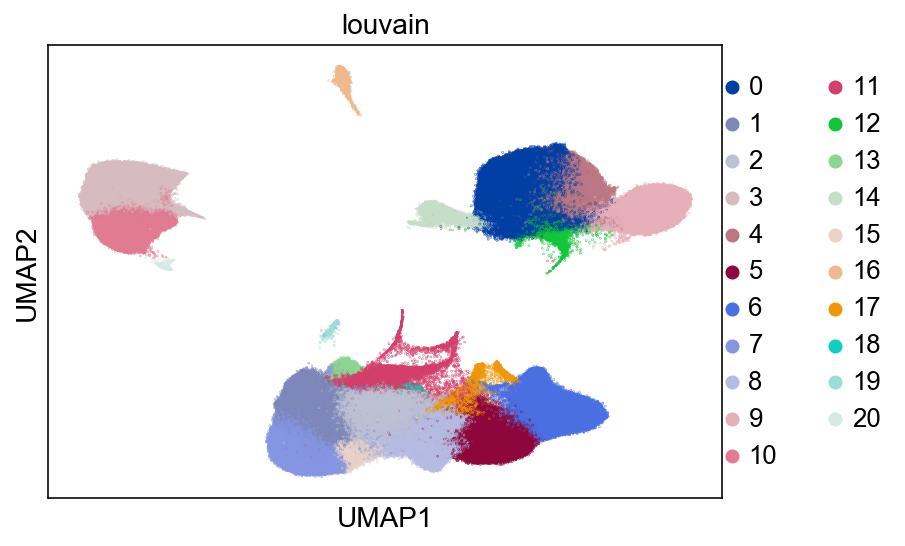

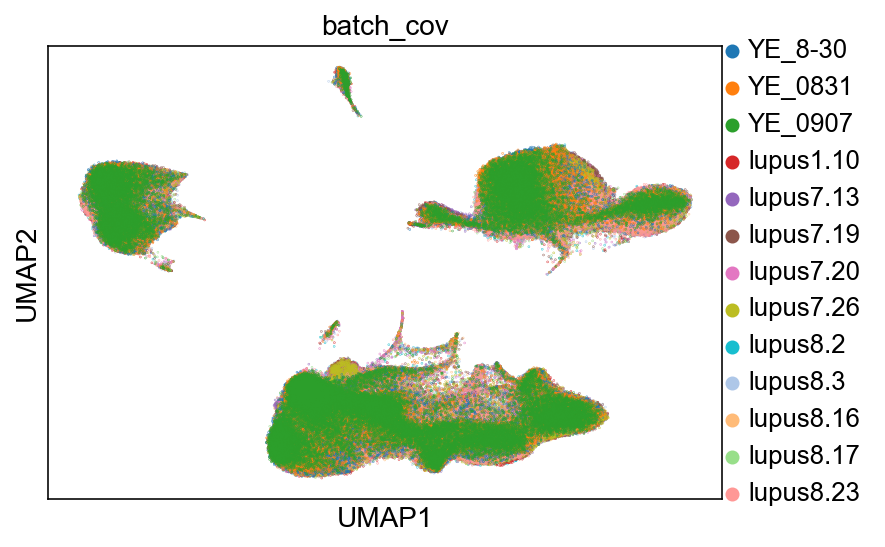

In [38]:
##sc.pl.tsne(adata, color='louvain')
##sc.pl.tsne(adata, color='batch_cov')
sc.pl.umap(adata, color='louvain')
sc.pl.umap(adata, color='batch_cov')

# Figure 1B: Projection and dropprint

## First, let's make the overall plot

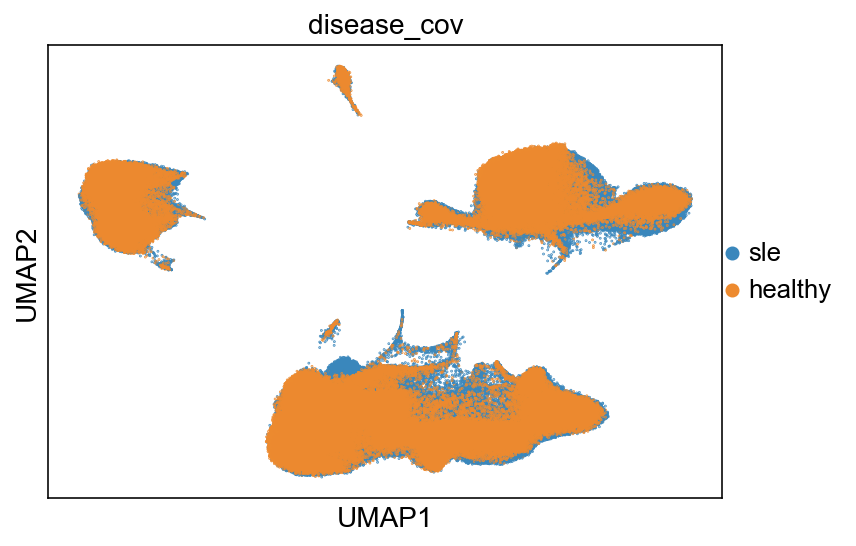

In [39]:
## Make disease plot (Fig. 1B)
## flipping the disease labels so that the healthy plots on top of the sle
adata.obs['disease_cov'] = pd.Categorical(adata.obs['disease_cov'],categories=['sle','healthy'], ordered=True)
adata.uns['disease_cov_colors'] = ['#3A87BC','#ED8A2F'];

##disease_tsne = sc.pl.tsne(adata, color='disease_cov', size=0.5)
disease_umap = sc.pl.umap(adata, color='disease_cov', size=0.5)

## testing returning an axes object which should allow for more customization
## disease_tsne2 = sc.pl.tsne(adata, color='disease_cov', size=0.5, show=False)

## flipping the disease/healthy labels back for all of the downstream analysis
adata.obs['disease_cov'] = pd.Categorical(adata.obs['disease_cov'],categories=['healthy','sle'], ordered=True)

## Now, let's make a plot for each of the 16 people in batch 1 as a demo of variability

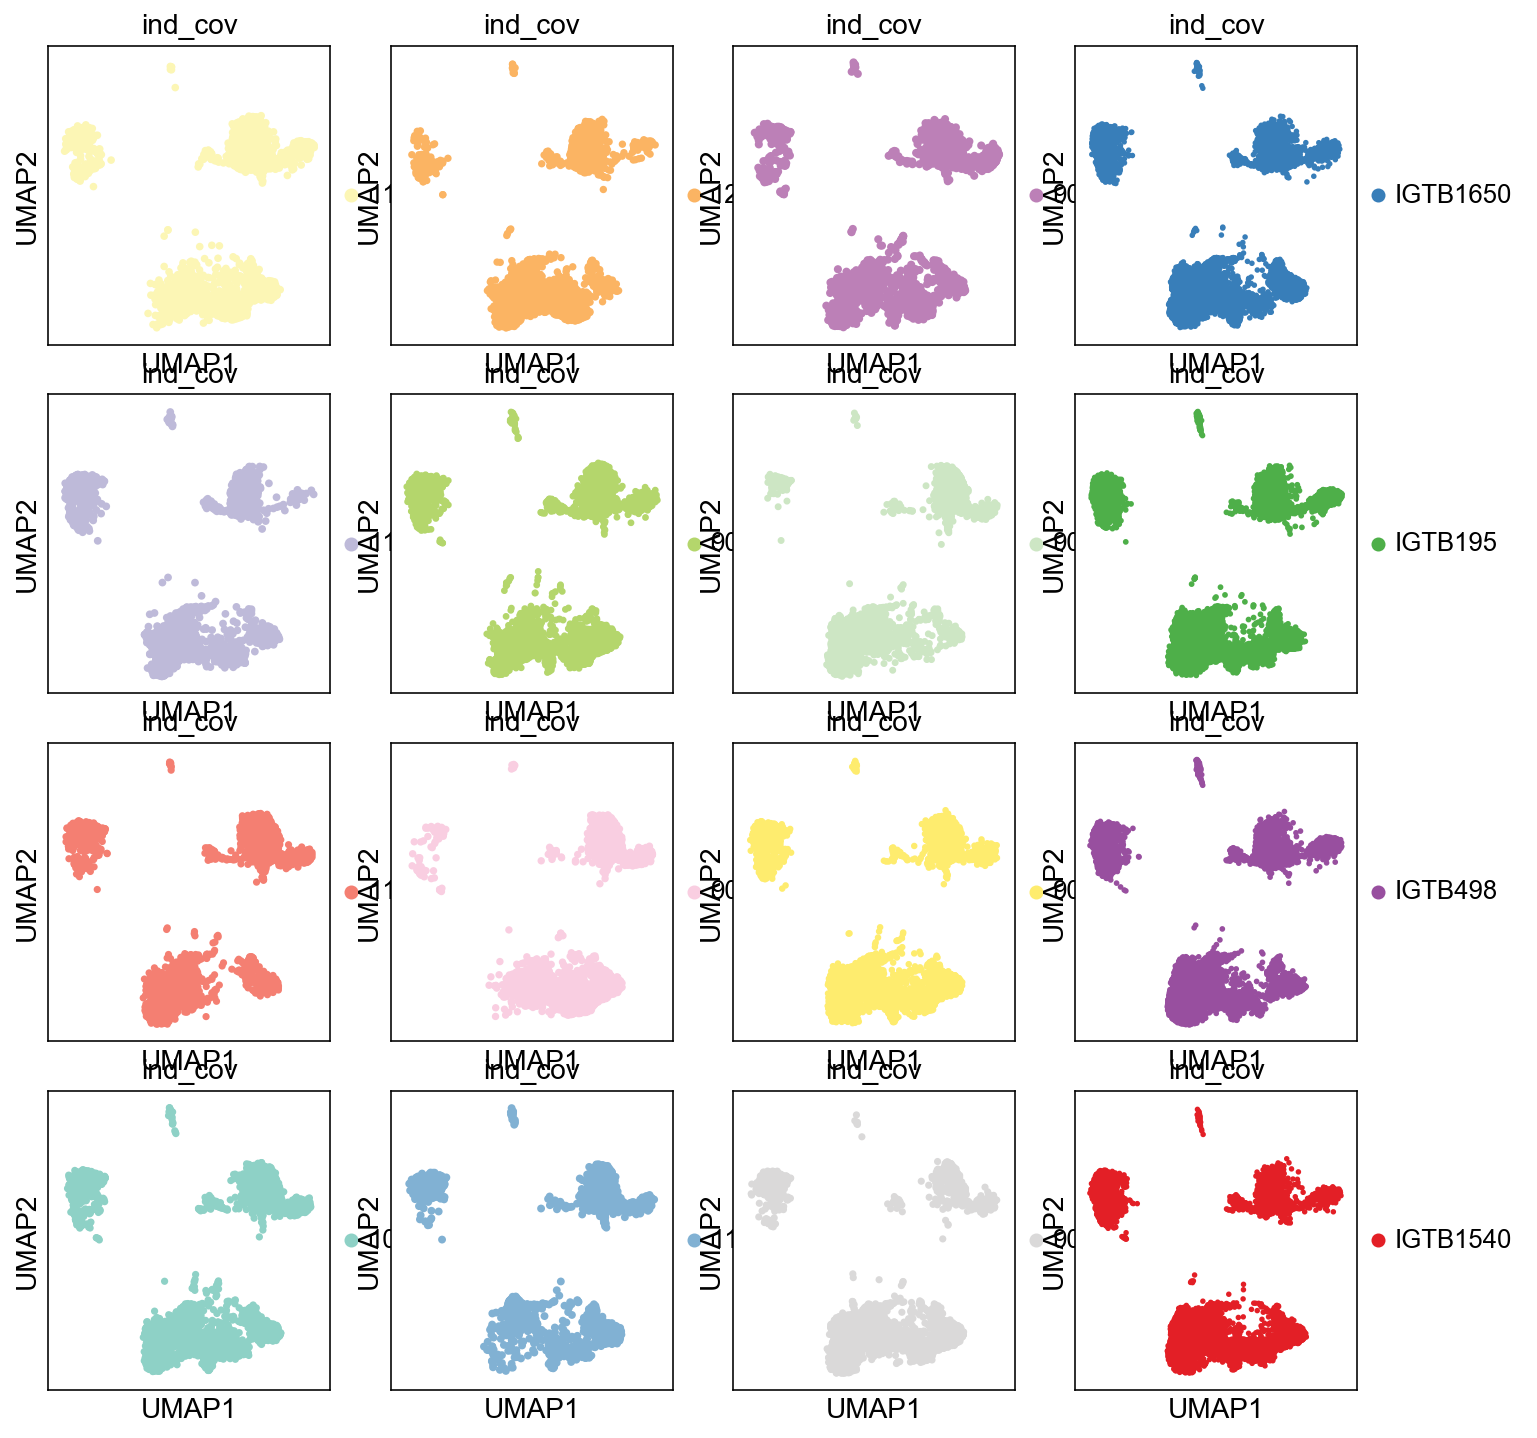

In [40]:
## let's plot 16 plots for the individuals in the first batch (Fig. 1B)
colors = ["#8ED1C6","#FCF6B5", "#BEBAD9", "#F47F72", "#81B1D3", "#FBB463", "#B4D66C", "#F9CEE1", "#DAD9D9", "#BC80B7", "#CDE6C4", "#FEEC6E", "#E31F26", "#387EB9", "#4EAF49", "#984F9F"];
batch_07_19_inds = adata.obs.ind_cov[adata.obs.batch_cov=='lupus7.19'].unique()
batch_07_19_inds = np.sort(batch_07_19_inds.categories.values);

fig,ax = plt.subplots(nrows=4,ncols=4, figsize=(10,10),sharex=True, sharey=True)
fig.tight_layout()

for ind_i in list(range(batch_07_19_inds.shape[0])) :
    ind = batch_07_19_inds[ind_i]
    col = colors[ind_i]
    sc.pl.umap(adata[adata.obs.ind_cov==ind,], color = "ind_cov", palette=[col,col], ax=ax[(ind_i-1)%4,math.floor(ind_i/4)])

# Figure 1C: Cell type annotation of projection

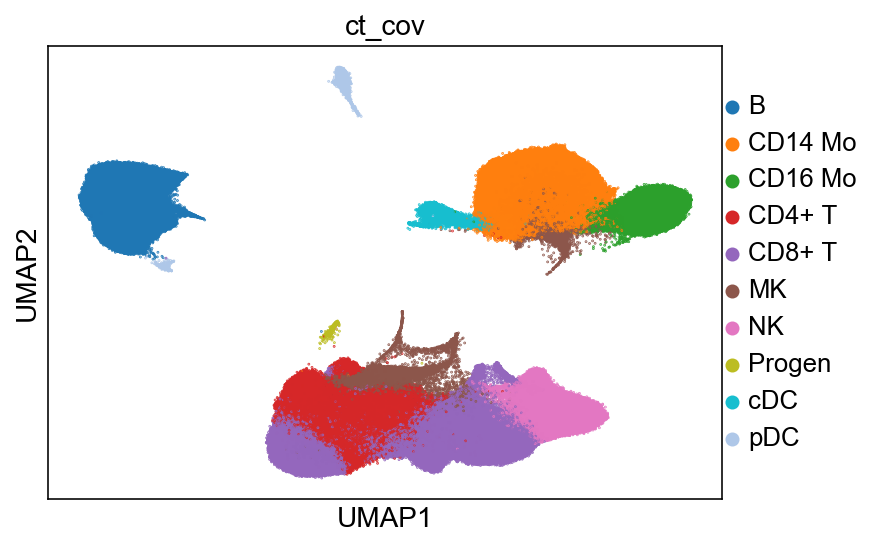

In [41]:
## Make cell type plot (Fig. 1C)
adata.uns['ct_cov_colors'] = sc.pl.palettes.vega_20_scanpy;
##celltype_tsne = sc.pl.tsne(adata, color='ct_cov', size=0.5)
celltype_umap = sc.pl.umap(adata, color='ct_cov', size=0.5)

# Figure 1D: Cell type proportion differences between case/control

## First got to compute the percentages

In [42]:
## Make proportion plots (Fig. 1D)
ind_count = adata.obs.groupby(['ind_cov','ct_cov','disease_cov','pop_cov'])['ct_cov'].count()

##ind_count = ind_count.reset_index(name="counts")
ind_count_sums = ind_count.groupby(level=[0]).sum()
ind_count_sums = ind_count_sums.reset_index(name="counts")

ind_perc = ind_count/ind_count.groupby(level=[0]).transform(sum)*100
ind_perc = ind_perc.reset_index(name="ct_perc")

## filter samples that have < 100 cells
ind_perc = ind_perc[ind_perc.ind_cov.isin(ind_count_sums.ind_cov[ind_count_sums.counts > 100])]


In [43]:
ct_group = pd.DataFrame( {'ct_cov':['B','CD14 Mo','CD16 Mo', 'CD4+ T', 'CD8+ T', 'MK', 'NK', 'cDC', 'pDC','Progen'], 'ct_group':['lymph', 'mono', 'mono', 'lymph','lymph', 'mkc','lymph','dc','pdc','progen']})
ind_perc.ind_cov = ind_perc.ind_cov.apply(lambda x: x.split('_')[0])
ind_count_sums.ind_cov = ind_count_sums.ind_cov.apply(lambda x: x.split('_')[0])
ind_perc = ind_perc.set_index('ct_cov').join(ct_group.set_index('ct_cov'))
ind_perc.ind_cov = ind_perc.ind_cov.astype("str")
ind_perc.reset_index(inplace=True)
ind_perc.ct_cov = ind_perc.ct_cov.astype('category')

print('as a proportion of total PBMC ')

for ct_i in list(range(10)) :
    ct = ind_perc.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc.ct_perc[ind_perc.ct_cov==ct]
    disease = ind_perc.disease_cov[ind_perc.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="sle"] = 0
    disease.values[disease=="healthy"] = 1
    disease = sm.add_constant(disease)
    ##data = data.assign(ct_perc=ct_perc)
    print('Cell type:'+ ct)
    est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    #print(effect)
    #print(pval)
    print('Beta='+str(effect)+', pvalue='+str(pval))

as a proportion of total PBMC 
Cell type:B
Beta=-0.004433207008341378, pvalue=0.9974793490473728
Cell type:CD14 Mo
Beta=-10.427027324780719, pvalue=1.5376984519022274e-09
Cell type:CD16 Mo
Beta=-1.631801132954799, pvalue=0.00018237277641263897
Cell type:CD4+ T
Beta=11.447727401986386, pvalue=1.3546030479179626e-12
Cell type:CD8+ T
Beta=0.4127013345302828, pvalue=0.7809308095983442
Cell type:MK
Beta=-1.295260685137836, pvalue=1.3084989436908429e-09
Cell type:NK
Beta=0.528644638438343, pvalue=0.46093898165811753
Cell type:Progen
Beta=-0.025691257753482077, pvalue=0.03379412295252342
Cell type:cDC
Beta=0.35742764841304414, pvalue=0.004676442121748409
Cell type:pDC
Beta=0.4895299387505321, pvalue=5.225040423854554e-19


## Next, let's plot the proportions

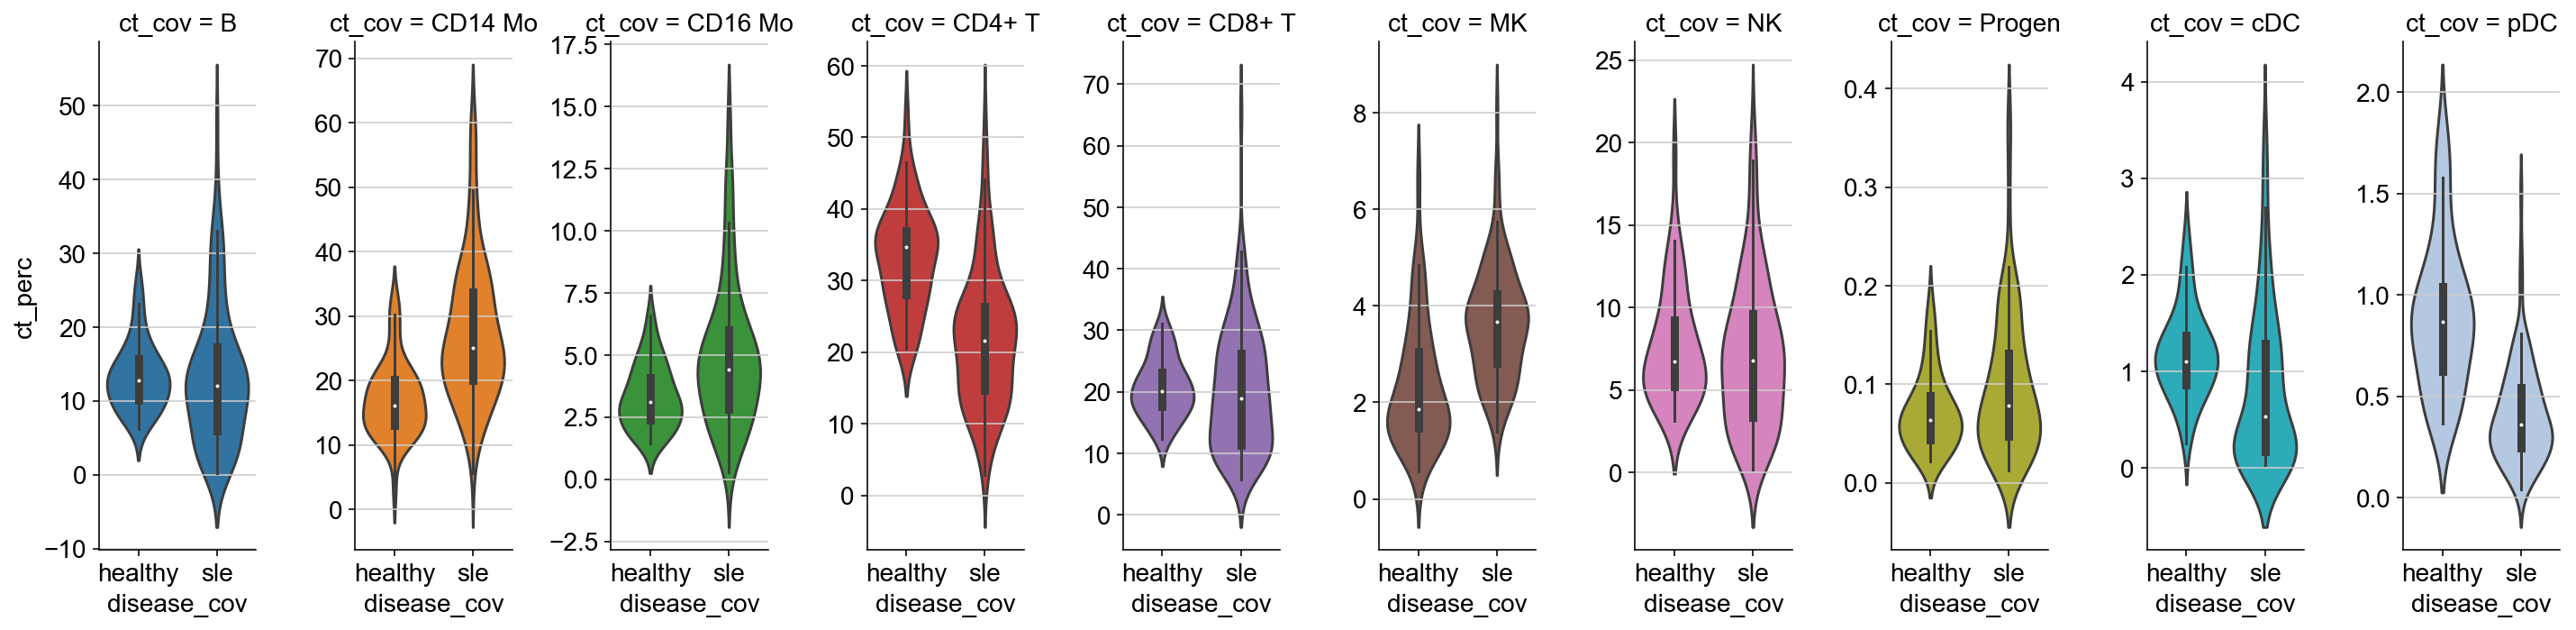

In [44]:
perc_plot = sns.catplot(x='disease_cov', y='ct_perc', hue='ct_cov', data=ind_perc, kind='violin', col='ct_cov', dodge=False, aspect=0.4, sharex=False, sharey=False)

#fig,ax = plt.subplots(nrows=1,ncols=10, figsize=(20,5))
#fig.tight_layout()

##for ct_i in list(range(10)) :
##    ct = ind_perc.ct_cov.cat.categories[ct_i]
##    sns.boxplot(x="disease_cov", y="ct_perc", data=ind_perc[ind_perc.ct_cov == ct], color=sc.pl.palettes.vega_20_scanpy[ct_i], ax=ax[ct_i])
##    sns.swarmplot(x="disease_cov", y="ct_perc", data=ind_perc[ind_perc.ct_cov == ct], color="0", size=3, ax=ax[ct_i])

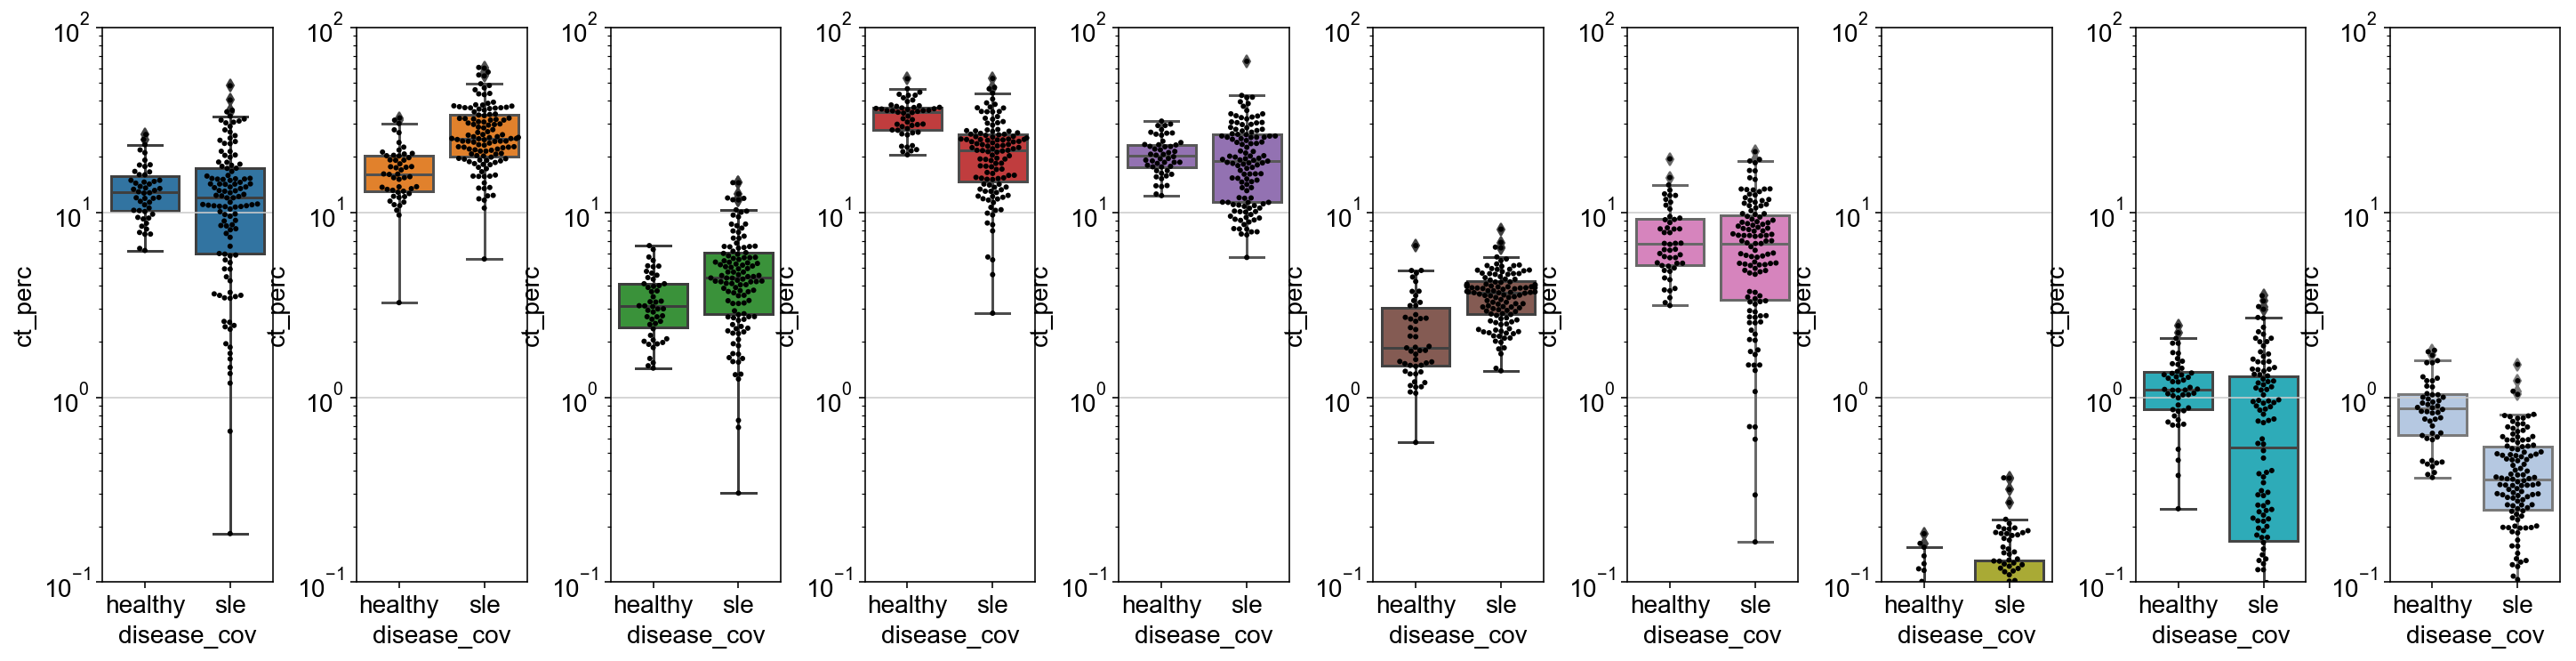

In [45]:
fig,ax = plt.subplots(nrows=1,ncols=10, figsize=(20,5))
fig.tight_layout()


for ct_i in list(range(10)) :
    ct = ind_perc.ct_cov.cat.categories[ct_i]
    ax[ct_i].set_yscale('log')
    ax[ct_i].set_ylim(0.1,100)
    sns.boxplot(x="disease_cov", y="ct_perc", data=ind_perc[ind_perc.ct_cov == ct], color=sc.pl.palettes.vega_20_scanpy[ct_i], ax=ax[ct_i])
    sns.swarmplot(x="disease_cov", y="ct_perc", data=ind_perc[ind_perc.ct_cov == ct], color="0", size=3, ax=ax[ct_i])

/Users/yimmieg/anaconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


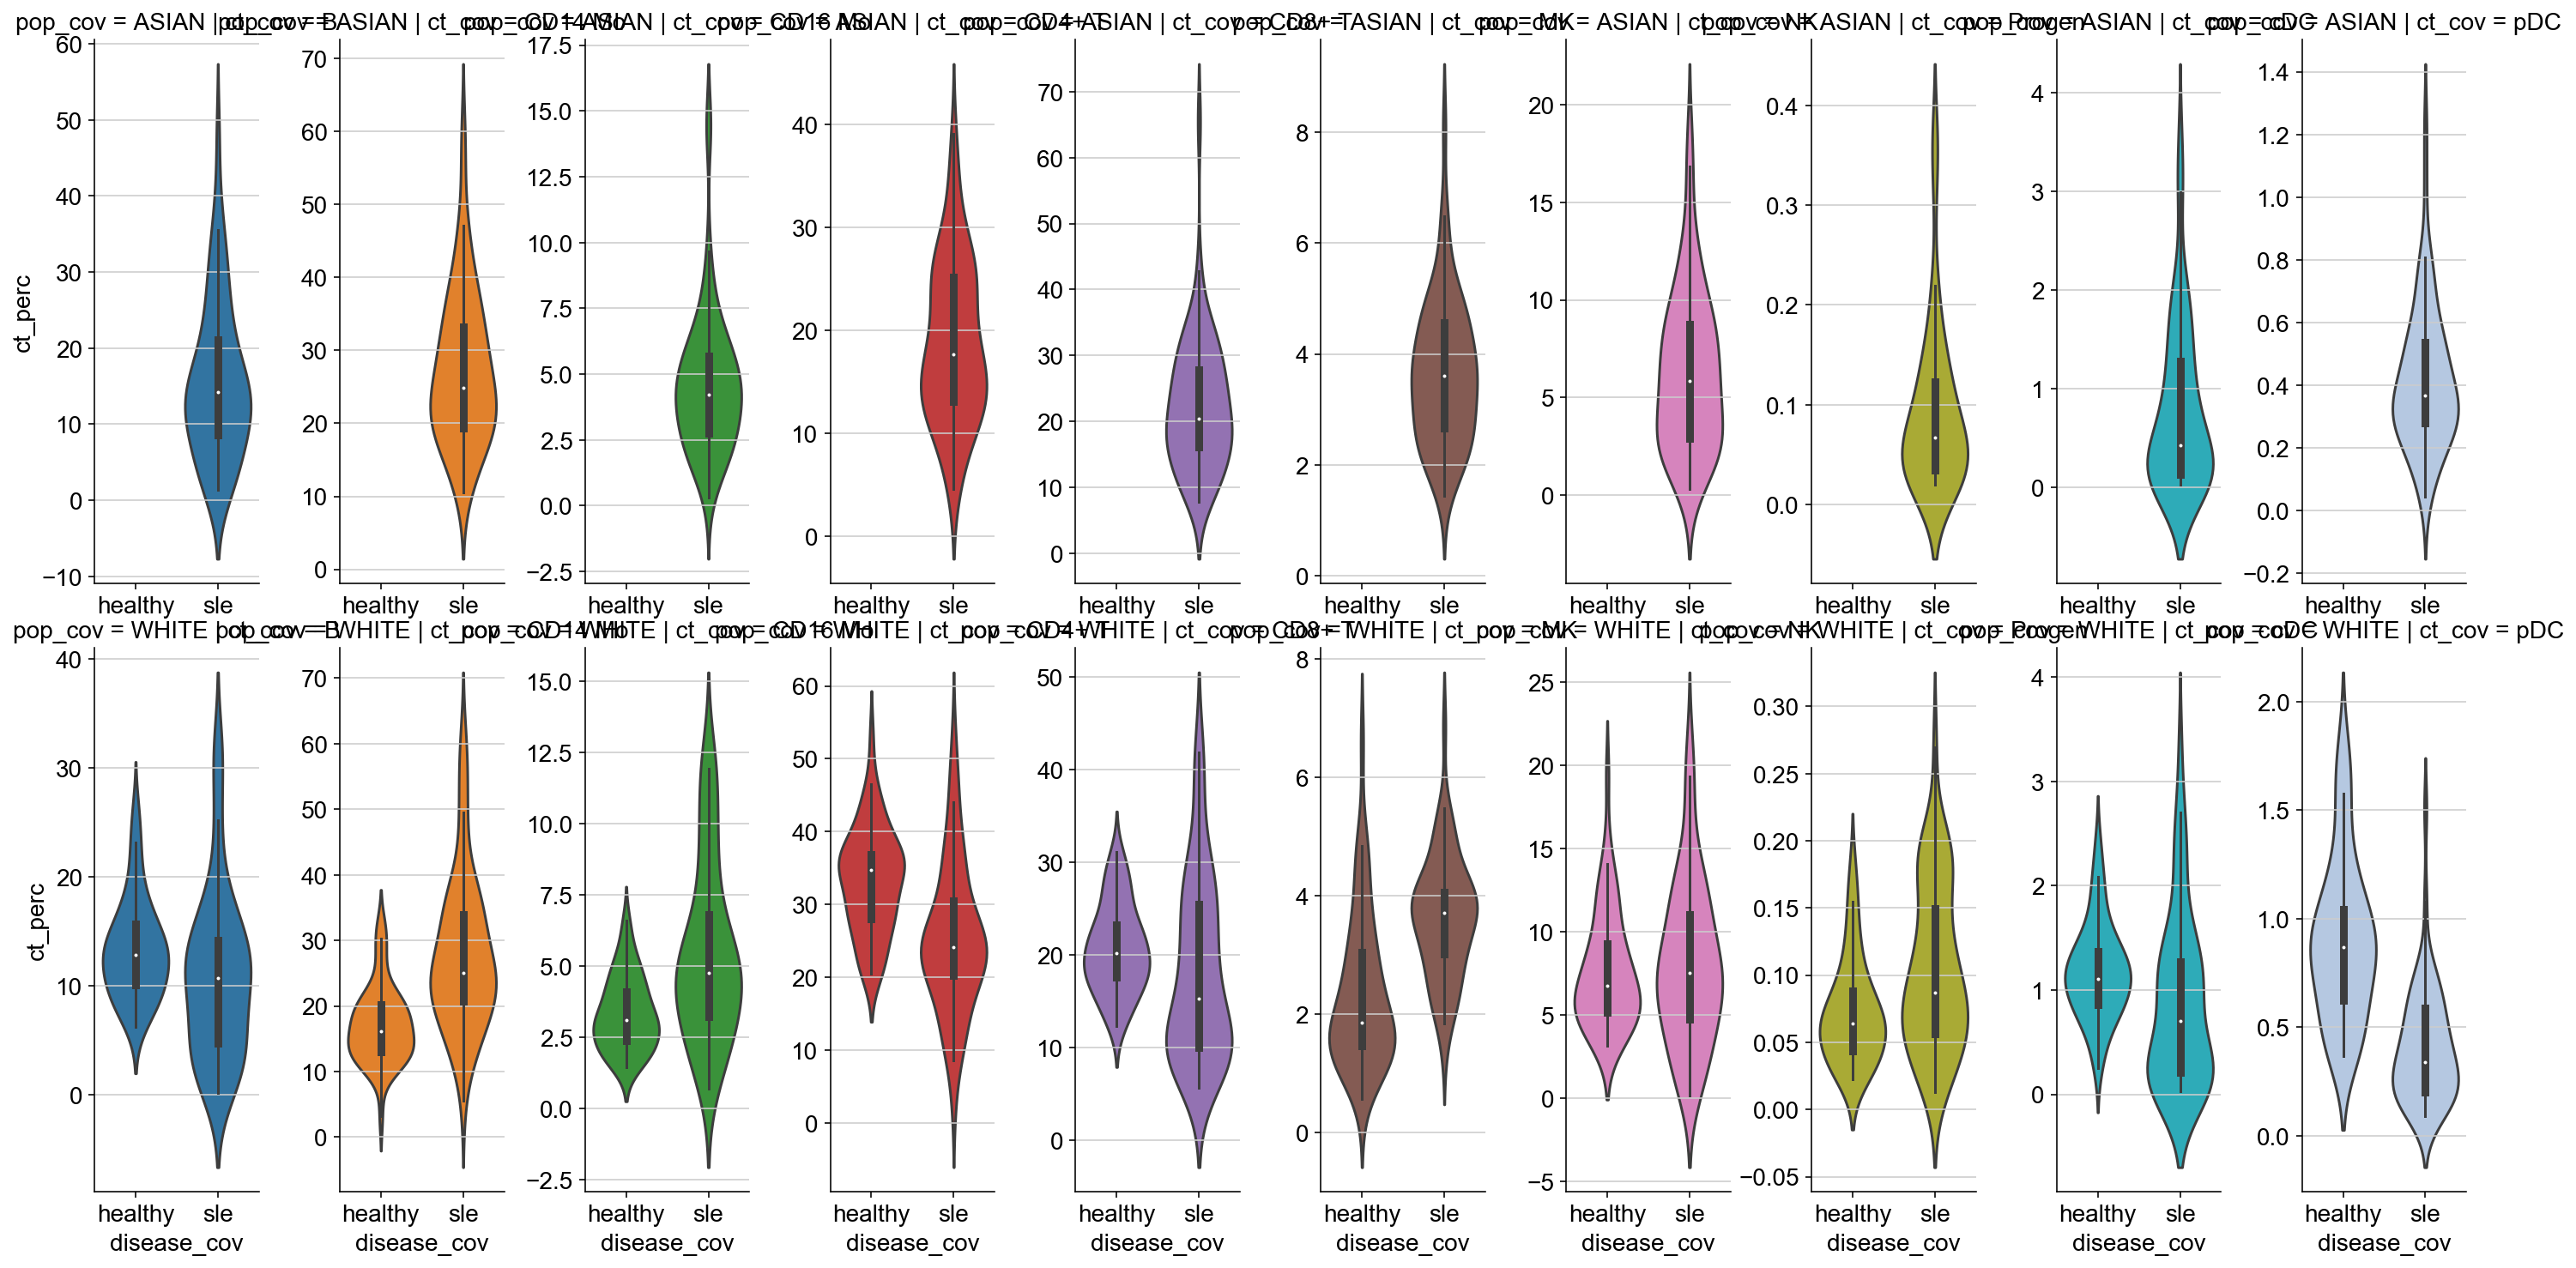

In [46]:
# fig,ax = plt.subplots(nrows=2,ncols=10, figsize=(20,10))
# fig.tight_layout()

# for ct_i in list(range(10)) :
#         ct = ind_perc.ct_cov.cat.categories[ct_i]
#         for pop_i in list(range(2)) :
#                 pop = ind_perc.pop_cov.cat.categories[pop_i]
                
#                 ##fig,ax = plt.subplots()
#                 ##fig.set_size_inches(2,8)
#                 sns.boxplot(x="disease_cov", y="ct_perc", data=ind_perc[(ind_perc.pop_cov == pop) & (ind_perc.ct_cov == ct)], color=sc.pl.palettes.vega_20_scanpy[ct_i], ax=ax[pop_i,ct_i])
#                 ##sns.swarmplot(x="disease_cov", y="ct_perc", data=ind_perc[(ind_perc.pop_cov == pop) & (ind_perc.ct_cov == ct)], color="0", size=3, ax=ax[pop_i,ct_i])


# for pop_i in list(range(2)) :
#     pop = ind_perc.pop_cov.cat.categories[pop_i]
#     perc_plot = sns.catplot(x='disease_cov', y='ct_perc', hue='ct_cov', data=ind_perc[(ind_perc.pop_cov == pop)], kind='violin', col='ct_cov', dodge=False, aspect=0.4, sharex=False, sharey=False)
    
perc_plot = sns.catplot(x='disease_cov', y='ct_perc', hue='ct_cov', row="pop_cov", data=ind_perc, kind='violin', col='ct_cov', dodge=False, aspect=0.4, sharex=False, sharey=False)


In [47]:
##ax = sns.catplot(x='disease_cov', y='ct_perc', hue='ct_cov', data=ind_perc, kind='box', col='ct_cov', height=8, aspect=1/4)
##ax.savefig("figures/boxplot.cat.png")

# Figure 1E: Correlation with EHR

## Some initial data wrangling

ok, there should be 127 lupus patients and 42 immvar donors, we only have estimated PBMC numbers for 11 of them so the final joined table will only have 

In [48]:
## Let's grab the clinical and labs data and compare to our single cell estimates
clues_clinical = pd.read_table("v2.clinical.data.txt", index_col=False)
clues_clinical.genotypeid = clues_clinical.genotypeid.apply(lambda x: x.split('_')[0])
clues_clinical.subjectid = clues_clinical.subjectid.astype("str")
joined = ind_perc.join(ind_count_sums.set_index('ind_cov'), on='ind_cov');
joined = joined.join(clues_clinical.set_index('genotypeid'), on='ind_cov')
##joined = ind_perc.join(clues_clinical.set_index('genotypeid'), on='ind_cov')

t1_labs = pd.read_table("T1labs.csv",sep=",")
t1_labs.SubjectID = t1_labs.SubjectID.astype("str")
joined = joined.join(t1_labs.set_index('SubjectID'), on='subjectid')

### test new code
joined.AbsBaso = joined.AbsBaso/1000
joined.AbsEosino = joined.AbsEosino/1000
joined.AbsLympho = joined.AbsLympho/1000
joined.AbsNeutro = joined.AbsNeutro/1000
joined.AbsMono = joined.AbsMono/1000

joined = joined.assign(pbmc = joined.WhiteBloodCell-joined.AbsNeutro-joined.AbsEosino-joined.AbsBaso)

joined[["subjectid",'WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount']] = joined[["subjectid",'WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount']].astype(str)

## now let's add in white blood cell counts for the immvar patients
immvar_pbmc = pd.read_table("immvar.pbmc.csv", index_col=False, sep=",")
immvar_pbmc.pbmc = immvar_pbmc.pbmc - (np.mean(immvar_pbmc.pbmc) - np.mean(joined.pbmc))
## this is not the most efficient code but will suffice for now
for i in list(range(12)) :
    igtb = immvar_pbmc.immvarid[i]
    joined.pbmc[joined.ind_cov==igtb] = immvar_pbmc.pbmc[i]

joined = joined.assign(estimate=joined.ct_perc/100*joined.pbmc)

joined[["ind_cov","disease_cov","ct_cov"]] = joined[["ind_cov","disease_cov","ct_cov"]].astype(str)
joined.plaquenilnow = joined.plaquenilnow.fillna(0)
joined.cellceptnow = joined.cellceptnow.fillna(0)
joined.steroralnow = joined.steroralnow.fillna(0)
joined.acrlymphopenia = joined.acrlymphopenia.fillna(0)


/Users/yimmieg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


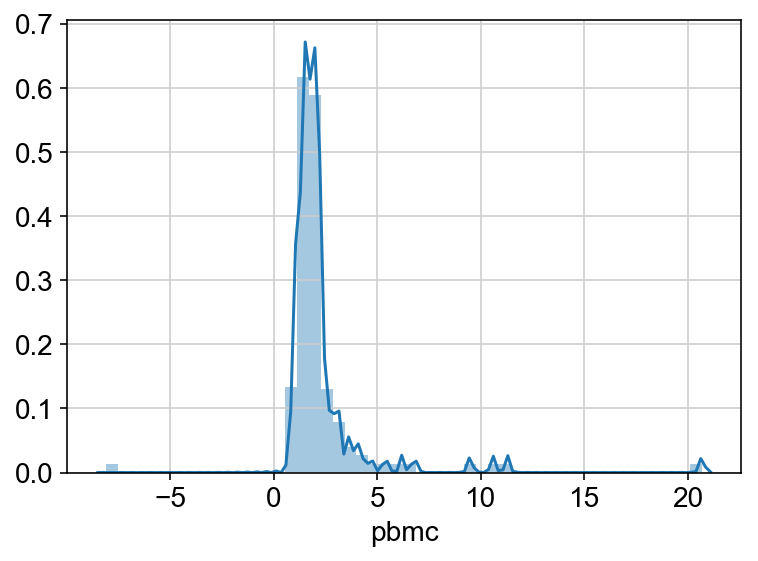

In [49]:
sns.distplot(joined.pbmc[~np.isnan(joined.pbmc)]);

ok, so current code joins to get estimates so for those samples with pbmc NAs, they will be filtered out

In [50]:
##joined_pivot = joined.pivot_table(index=['ind_cov',"disease_cov","pbmc","plaquenilnow","cellceptnow","steroralnow","acrlymphopenia"], columns="ct_cov", values="estimate")
joined_pivot = joined.pivot_table(index=['ind_cov',"disease_cov","pbmc","counts","plaquenilnow","cellceptnow","steroralnow","acrlymphopenia"], columns="ct_cov", values="estimate")
joined_pivot.reset_index(inplace=True)
joined_pivot.to_csv(name+"_joined_pivot_estimates.txt")

## this does not require the pbmc counts
joined_pivot_perc = joined.pivot_table(index=['ind_cov',"disease_cov","counts","plaquenilnow","cellceptnow","steroralnow","acrlymphopenia"], columns="ct_cov", values="ct_perc")
joined_pivot_perc.reset_index(inplace=True)
joined_pivot_perc.to_csv(name+"_joined_pivot_ct_perc.txt")

joined_pivot = joined_pivot[joined_pivot.pbmc > 0]
joined_pivot = joined_pivot[joined_pivot.pbmc < 10]

joined_pivot.disease_cov = pd.Categorical(joined_pivot.disease_cov,categories=['healthy','sle'], ordered=True)


##joined_agg = joined.groupby(['ind_cov','subjectid','disease_cov','ct_group','WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount','pbmc'])['ct_perc'].sum()
joined_agg = joined.groupby(['ind_cov','subjectid','disease_cov','ct_group','plaquenilnow','cellceptnow','steroralnow',"acrlymphopenia",'WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount','pbmc'])['ct_perc'].sum()

joined_agg = joined_agg.reset_index(name='ct_perc')

joined_agg[['WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount','pbmc']] = joined_agg[['WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount','pbmc']].astype(float)

joined_agg = joined_agg.assign(estimate=joined_agg.ct_perc/100*joined_agg.pbmc)
joined_agg[["subjectid","disease_cov",'WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount']] = joined_agg[["subjectid","disease_cov",'WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount']].astype(str)
joined_agg_pivot = joined_agg.pivot_table(index=['ind_cov', "subjectid", "pbmc","disease_cov",'plaquenilnow','cellceptnow','steroralnow',"acrlymphopenia","WhiteBloodCell","AbsMono",'AbsBaso',"AbsLympho","AbsNeutro","AbsEosino","PlatCount"], columns="ct_group", values="estimate")
joined_agg_pivot.reset_index(inplace=True);

joined_agg[["subjectid",'WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount']] = joined_agg[["subjectid",'WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount']].astype(float)
joined_agg_pivot[["subjectid",'WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount']] = joined_agg_pivot[["subjectid",'WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount']].astype(float)

## filter for some really bad samples
joined_agg_pivot_clues = joined_agg_pivot[joined_agg_pivot.AbsMono > 5/1000]
joined_agg_pivot_clues = joined_agg_pivot_clues[joined_agg_pivot.AbsLympho > 5/1000]
joined_agg_pivot_clues = joined_agg_pivot_clues[joined_agg_pivot.WhiteBloodCell > 0]

joined_agg_clues = joined_agg[joined_agg.AbsMono > 5/1000]
joined_agg_clues = joined_agg_clues[joined_agg.AbsLympho > 5/1000]
joined_agg_clues = joined_agg_clues[joined_agg.WhiteBloodCell > 0]

/Users/yimmieg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/yimmieg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/yimmieg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/yimmieg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


## Plot correlation for monocytes and lymphocytes

(0.9634907835904207, 6.5508604380337946e-62)
(0.8766485861582891, 3.8365749311081653e-35)


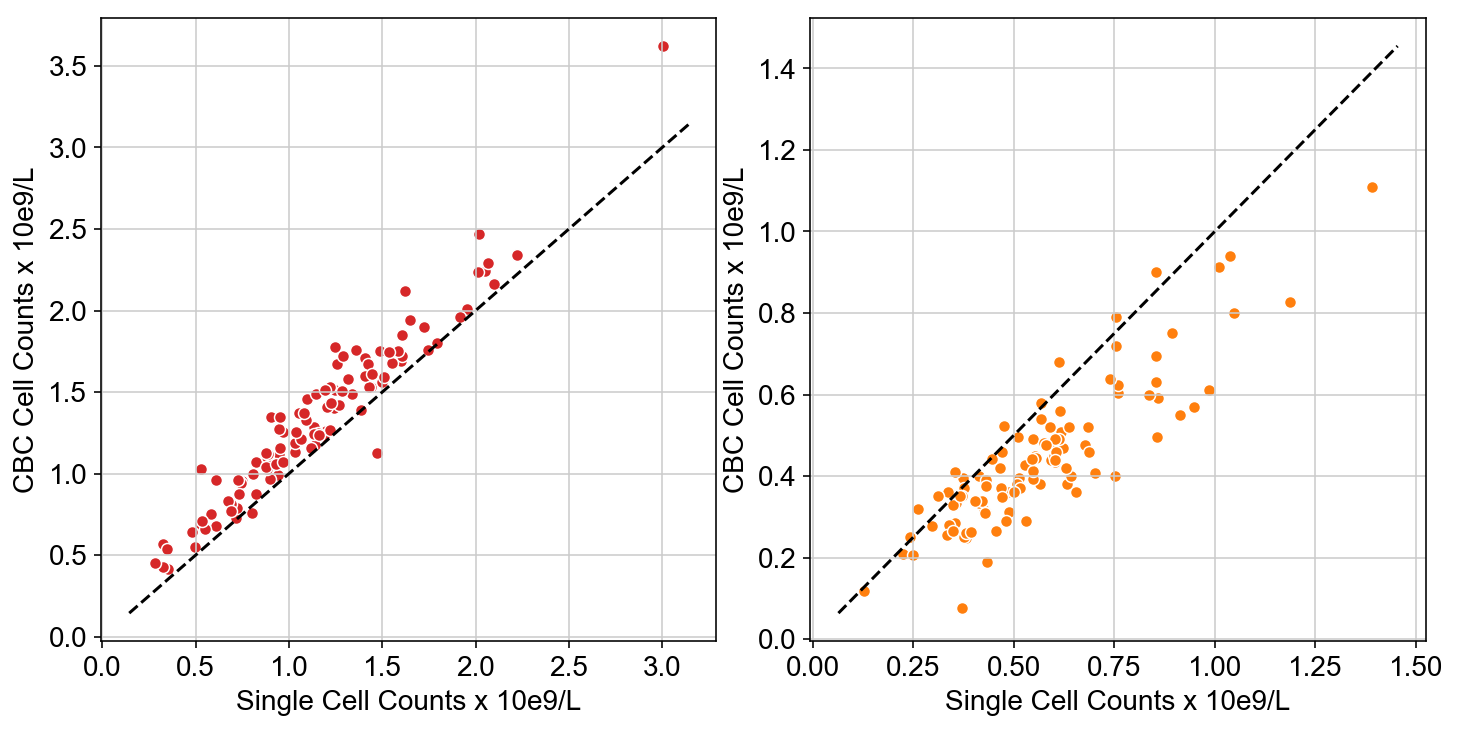

In [51]:
## calculate correlation
lympho_cor = stats.pearsonr(joined_agg_pivot_clues.lymph, joined_agg_pivot_clues.AbsLympho)
mono_cor = stats.pearsonr(joined_agg_pivot_clues.mono, joined_agg_pivot_clues.AbsMono)

fig,ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
fig.tight_layout()

sns.scatterplot(x='lymph', y='AbsLympho', data=joined_agg_pivot_clues, color='#d62728',ax=ax[0])
ax[0].set(xlabel="Single Cell Counts x 10e9/L", ylabel="CBC Cell Counts x 10e9/L")
ax[0].plot(ax[0].get_xlim(), ax[0].get_xlim(), '--', color='#000000')

sns.scatterplot(x='mono', y='AbsMono', data=joined_agg_pivot_clues, color='#ff7f0e',ax=ax[1])
ax[1].set(xlabel="Single Cell Counts x 10e9/L", ylabel="CBC Cell Counts x 10e9/L")
ax[1].plot(ax[1].get_xlim(), ax[1].get_xlim(), '--', color='#000000')


print(lympho_cor)
print(mono_cor)

## Plot cell abundance

In [52]:
joined_pivot_perc

ct_cov   ind_cov disease_cov  counts  plaquenilnow  cellceptnow  steroralnow  \
0           1004         sle    2896           1.0          0.0          0.0   
1           1014         sle    3027           1.0          0.0          1.0   
2           1019         sle    4020           1.0          0.0          0.0   
3           1045         sle    3277           1.0          0.0          1.0   
4           1051         sle    2726           1.0          1.0          1.0   
5           1054         sle    3645           0.0          0.0          1.0   
6           1056         sle    4418           1.0          0.0          0.0   
7           1078         sle    2878           0.0          0.0          1.0   
8           1110         sle    3830           0.0          0.0          1.0   
9           1127         sle    3638           1.0          0.0          1.0   
10          1132         sle    4489           1.0          1.0          0.0   
11          1195         sle    3198           1.0          1.0          0.0   
12          1196         sle    3497           1.0          1.0          1.0   
13          1197         sle    3954           0.0          0.0          0.0   
14          1203         sle    4197           1.0          0.0          1.0   
15          1219         sle    3993           0.0          0.0          0.0   
16          1221         sle    4159           1.0          0.0          0.0   
17          1243         sle    3859           1.0          0.0          1.0   
18          1250         sle    3971           1.0          0.0          1.0   
19          1251         sle    3943           0.0          0.0          0.0   
20          1259         sle    3731           1.0          0.0          0.0   
21          1262         sle    7557           1.0          1.0          1.0   
22          1270         sle    5976           0.0          1.0          1.0   
23          1279         sle    7672           1.0          0.0          0.0   
24          1297         sle    3052           1.0          0.0          0.0   
25          1324         sle    4138           1.0          0.0          1.0   
26          1326         sle    4465           1.0          1.0          1.0   
27          1329         sle    3560           1.0          1.0          1.0   
28          1334         sle    4616           1.0          1.0          1.0   
29          1338         sle    3707           0.0          0.0          0.0   
..           ...         ...     ...           ...          ...          ...   
139     IGTB1828     healthy    3083           0.0          0.0          0.0   
140     IGTB1840     healthy    3625           0.0          0.0          0.0   
141     IGTB1844     healthy    4064           0.0          0.0          0.0   
142     IGTB1871     healthy    3773           0.0          0.0          0.0   
143     IGTB1895     healthy    3688           0.0          0.0          0.0   
144     IGTB1901     healthy    2898           0.0          0.0          0.0   
145     IGTB1906     healthy    3438           0.0          0.0          0.0   
146     IGTB1908     healthy    3136           0.0          0.0          0.0   
147     IGTB1913     healthy    3877           0.0          0.0          0.0   
148     IGTB1916     healthy    2715           0.0          0.0          0.0   
149     IGTB1921     healthy    5680           0.0          0.0          0.0   
150      IGTB195     healthy    8625           0.0          0.0          0.0   
151     IGTB1952     healthy    3042           0.0          0.0          0.0   
152     IGTB1966     healthy    4612           0.0          0.0          0.0   
153     IGTB1974     healthy    2757           0.0          0.0          0.0   
154     IGTB1982     healthy    2962           0.0          0.0          0.0   
155     IGTB1987     healthy    3154           0.0          0.0          0.0   
156     IGTB1996     healthy    3066           0.0          0.0          0.0   


In [53]:
pd.DataFrame(data={'ind_cov':joined_agg_pivot.ind_cov,'mono_prop':joined_agg_pivot.mono/joined_agg_pivot.pbmc,'lymph_prop':joined_agg_pivot.lymph/joined_agg_pivot.pbmc})

ind_cov  mono_prop  lymph_prop
0         1004   0.228246    0.735152
1         1014   0.378593    0.580112
2         1019   0.182587    0.781343
3         1045   0.394568    0.579188
4         1051   0.389215    0.564563
5         1054   0.324005    0.627984
6         1056   0.311906    0.618832
7         1078   0.382557    0.573662
8         1110   0.410183    0.548042
9         1127   0.123145    0.814733
10        1132   0.385832    0.542214
11        1195   0.434334    0.517511
12        1196   0.340292    0.618816
13        1197   0.151998    0.815883
14        1203   0.224446    0.721468
15        1219   0.253694    0.694215
16        1221   0.402741    0.550854
17        1243   0.256543    0.669085
18        1250   0.294636    0.649459
19        1251   0.285569    0.686787
20        1259   0.314929    0.645671
21        1262   0.422522    0.516078
22        1270   0.378347    0.573126
23        1279   0.419447    0.535063
24        1297   0.307012    0.642529
25        1324   0.251812    0.702513
26        1326   0.520941    0.405823
27        1329   0.463764    0.447191
28        1334   0.311742    0.647747
29        1338   0.386296    0.560291
..         ...        ...         ...
101  902991200   0.178178    0.773589
102  903398200   0.328878    0.624716
103  903648200   0.151625    0.809497
104  903884200   0.306183    0.641984
105  903965200   0.238086    0.728593
106  904007200   0.179112    0.779301
107  904025200   0.368984    0.571004
108  904033200   0.218660    0.745965
109  904049200   0.352265    0.611900
110  904194200   0.074891    0.882969
111  904236200   0.327359    0.618870
112  904326200   0.195464    0.758639
113  904344200   0.398622    0.533147
114  904405200   0.359038    0.577113
115  904425200   0.349747    0.601857
116  904463200   0.489747    0.450945
117  904464200   0.171074    0.768595
118  904477200   0.265067    0.692147
119   IGTB1290   0.214817    0.715513
120   IGTB1372   0.142424    0.818473
121   IGTB1539   0.069709    0.888298
122   IGTB1575   0.161725    0.788433
123   IGTB1650   0.129892    0.825710
124    IGTB195   0.195942    0.751536
125    IGTB256   0.171787    0.761318
126    IGTB469   0.181244    0.764771
127    IGTB498   0.166260    0.769077
128    IGTB514   0.160393    0.789499
129    IGTB670   0.139239    0.826057
130    IGTB884   0.125296    0.814027

[131 rows x 3 columns]

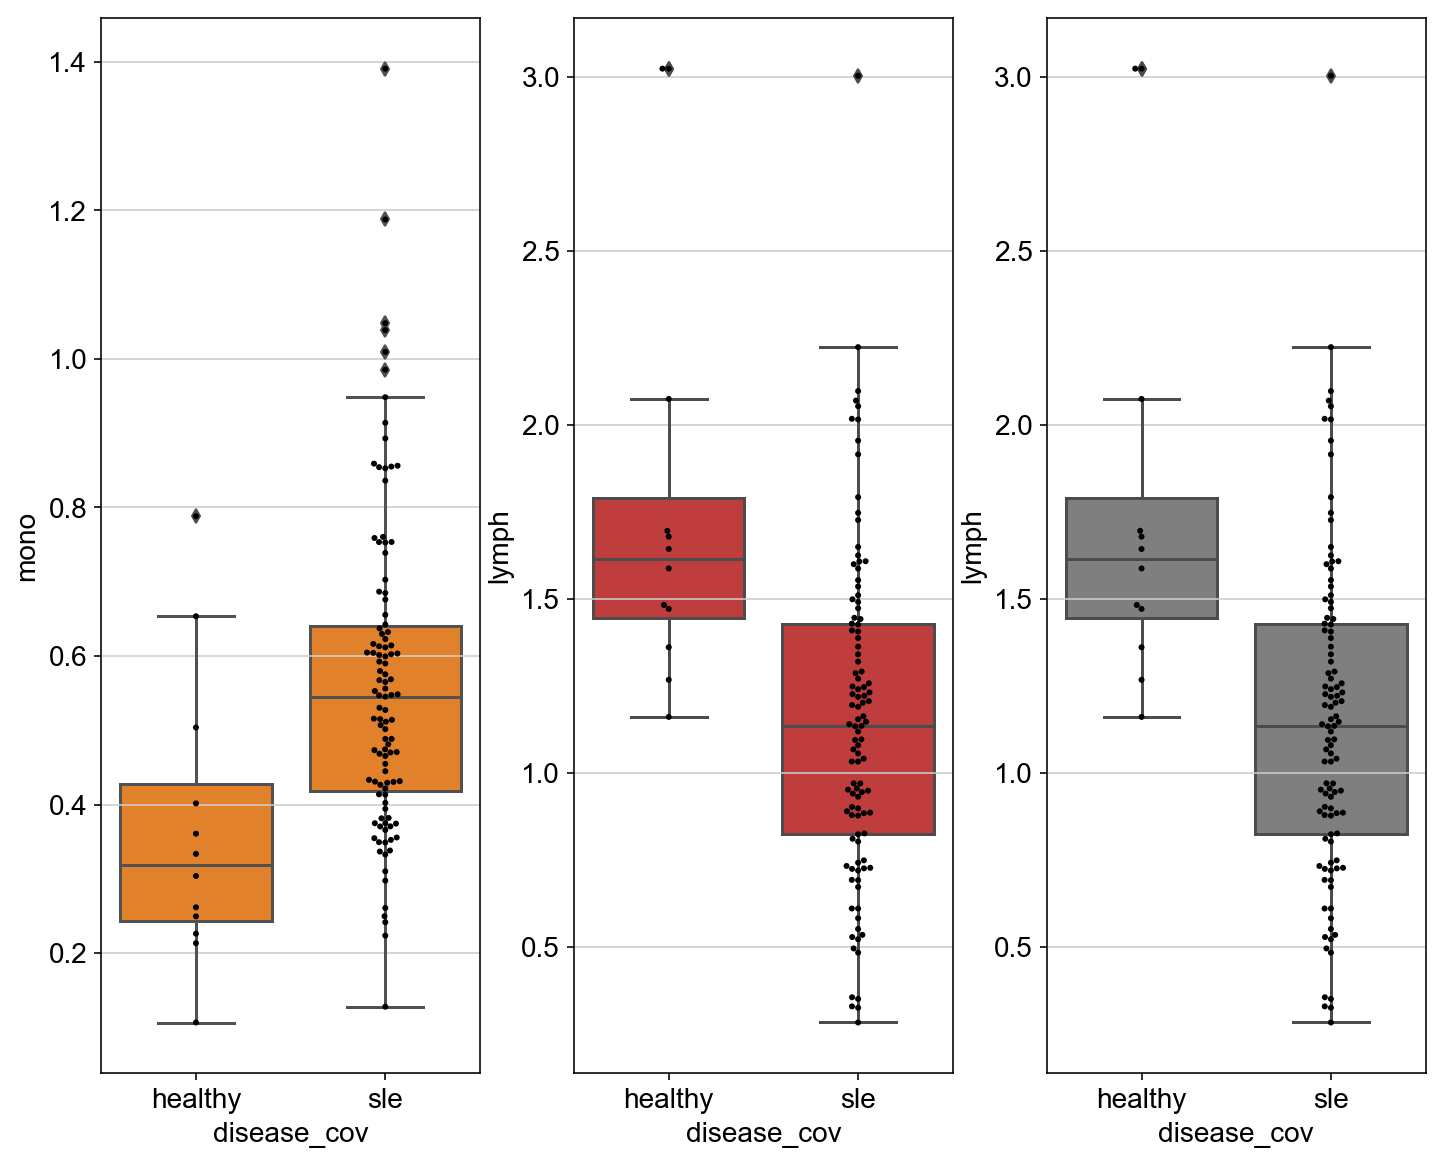

In [54]:
## now let's also plot the monocyte and lymphocyte counts between sle and control
## immvar samples are
##IGTB1290 IGTB1372 IGTB141 IGTB143 IGTB1506 IGTB1539 IGTB1540 IGTB1542 IGTB1575 IGTB1650 IGTB1921 IGTB195 IGTB256 IGTB469 IGTB498 IGTB508 IGTB514 IGTB645 IGTB670 IGTB826 IGTB884 IGTB986

joined_agg.disease_cov = pd.Categorical(joined_agg.disease_cov,categories=['healthy','sle'], ordered=True)
joined_agg_pivot.disease_cov = pd.Categorical(joined_agg_pivot.disease_cov,categories=['healthy','sle'], ordered=True)


fig,ax = plt.subplots(nrows=1,ncols=3, figsize=(10,8))
fig.tight_layout()

for cg_i in [0, 1,2] :
    cg = ['mono', 'lymph','lymph'][cg_i]
    sns.boxplot(x="disease_cov", y=cg, data=joined_agg_pivot[~(joined_agg_pivot.AbsMono < 5/1000)], color=['#ff7f0e','#d62728','#7f7f7f'][cg_i], ax=ax[cg_i])
    sns.swarmplot(x="disease_cov", y=cg, data=joined_agg_pivot[~(joined_agg_pivot.AbsMono < 5/1000)], color="0", size=3, ax=ax[cg_i])


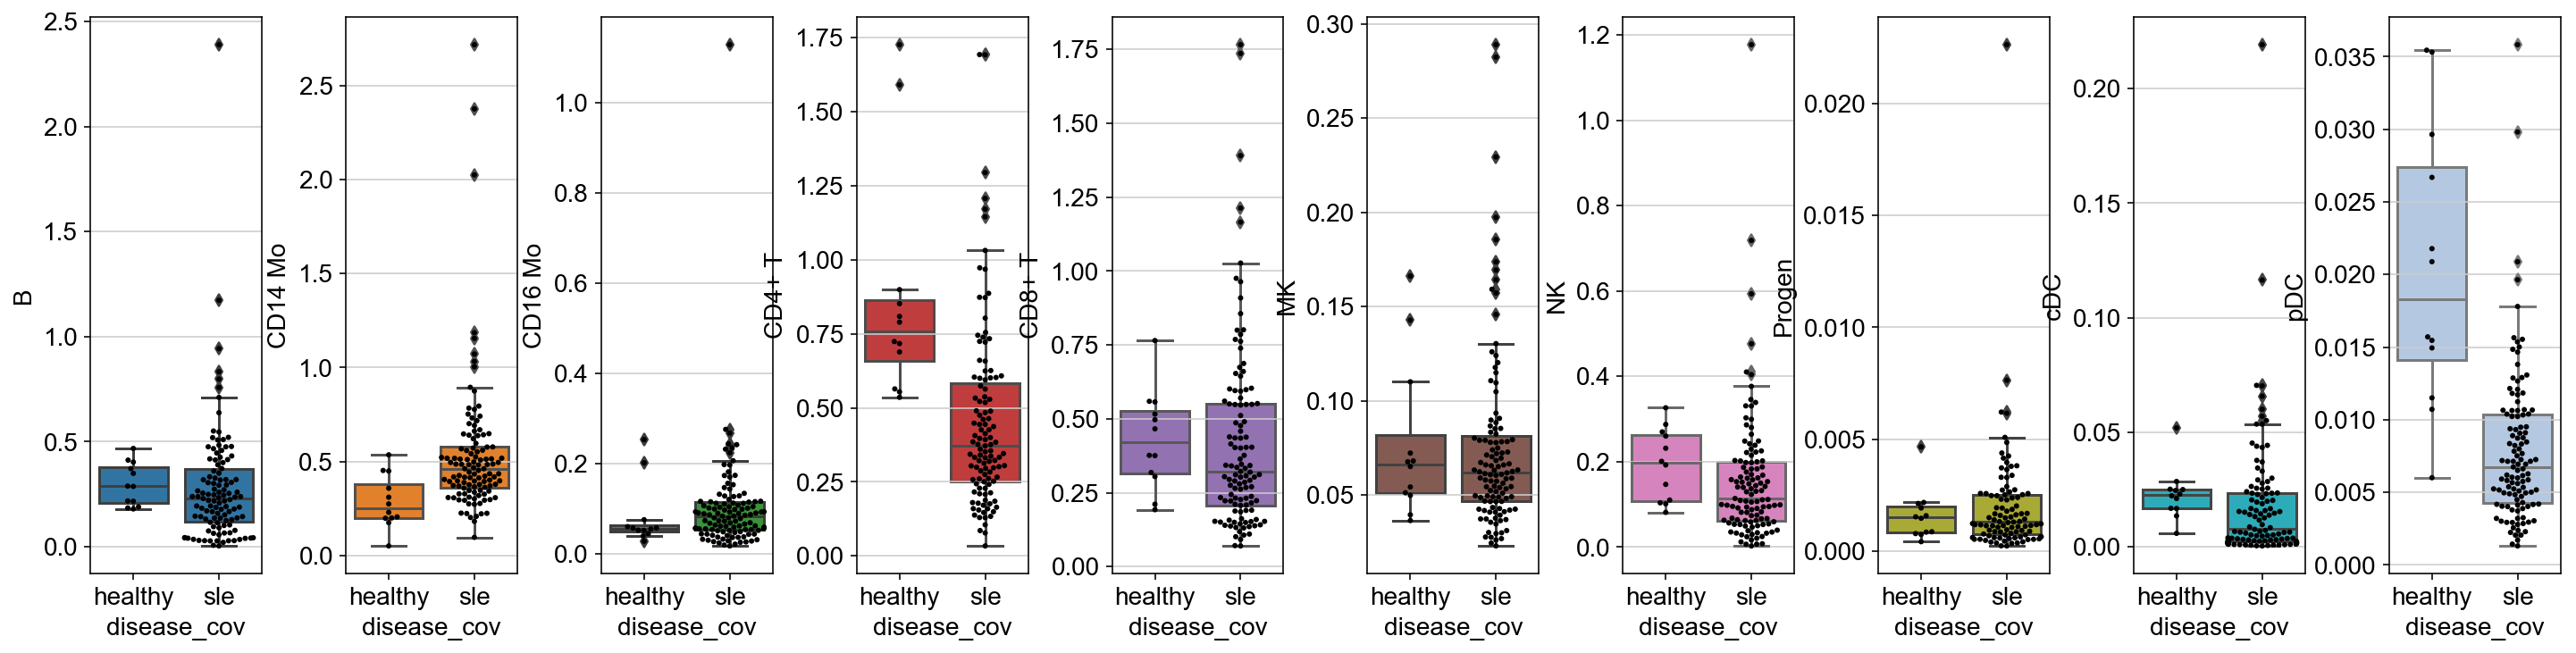

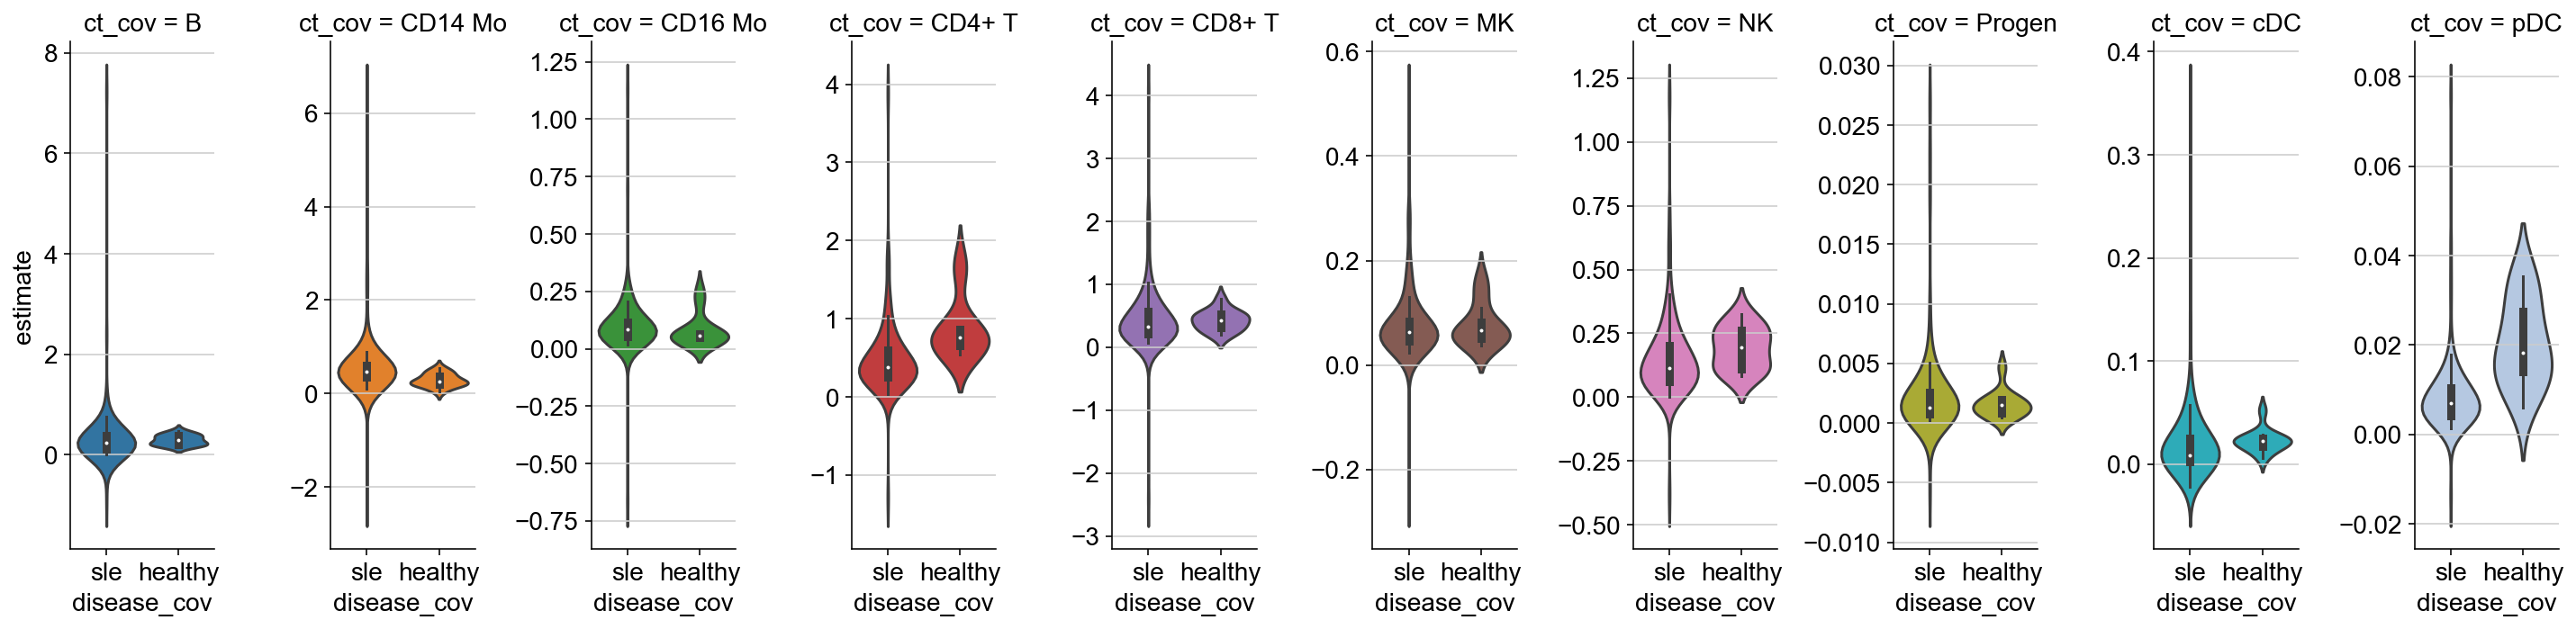

In [55]:
fig,ax = plt.subplots(nrows=1,ncols=10, figsize=(20,5))
fig.tight_layout()

for ct_i in list(range(10)) :
    ct = ind_perc.ct_cov.cat.categories[ct_i]
    sns.boxplot(x="disease_cov", y=ct, data=joined_pivot, color=sc.pl.palettes.vega_20_scanpy[ct_i], ax=ax[ct_i])
    sns.swarmplot(x="disease_cov", y=ct, data=joined_pivot, color="0", size=3, ax=ax[ct_i])
    
perc_plot = sns.catplot(x='disease_cov', y='estimate', hue='ct_cov', data=joined, kind='violin', col='ct_cov', dodge=False, aspect=0.4, sharex=False, sharey=False)


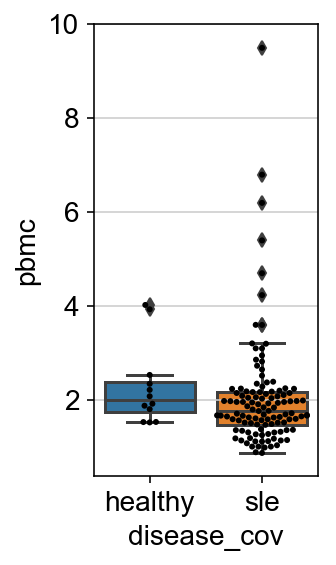

In [56]:
fig,ax = plt.subplots()
fig.set_size_inches(2,4)
ax = sns.boxplot(x="disease_cov", y="pbmc", data=joined_pivot)
ax = sns.swarmplot(x="disease_cov", y="pbmc", data=joined_pivot, color="0", size=3)


# Figure 1F: Validation of lymphopenia in EHR

/Users/yimmieg/anaconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


Cell type:pDC,Race:White or Caucasian
Beta=0.026421768048560033, pvalue=0.25650563848207053
Cell type:pDC,Race:Black or African American
Beta=-0.0447331932773108, pvalue=0.21628339429165347
Cell type:pDC,Race:Asian
Beta=-0.015488095238095247, pvalue=0.4957218204336783
Cell type:pDC,Race:White or Caucasian
Beta=-0.4990948275862069, pvalue=8.000617380532096e-09
Cell type:pDC,Race:Black or African American
Beta=-0.7360336134453774, pvalue=0.0001811104138938749
Cell type:pDC,Race:Asian
Beta=-0.7384702380952379, pvalue=1.659635608701236e-14


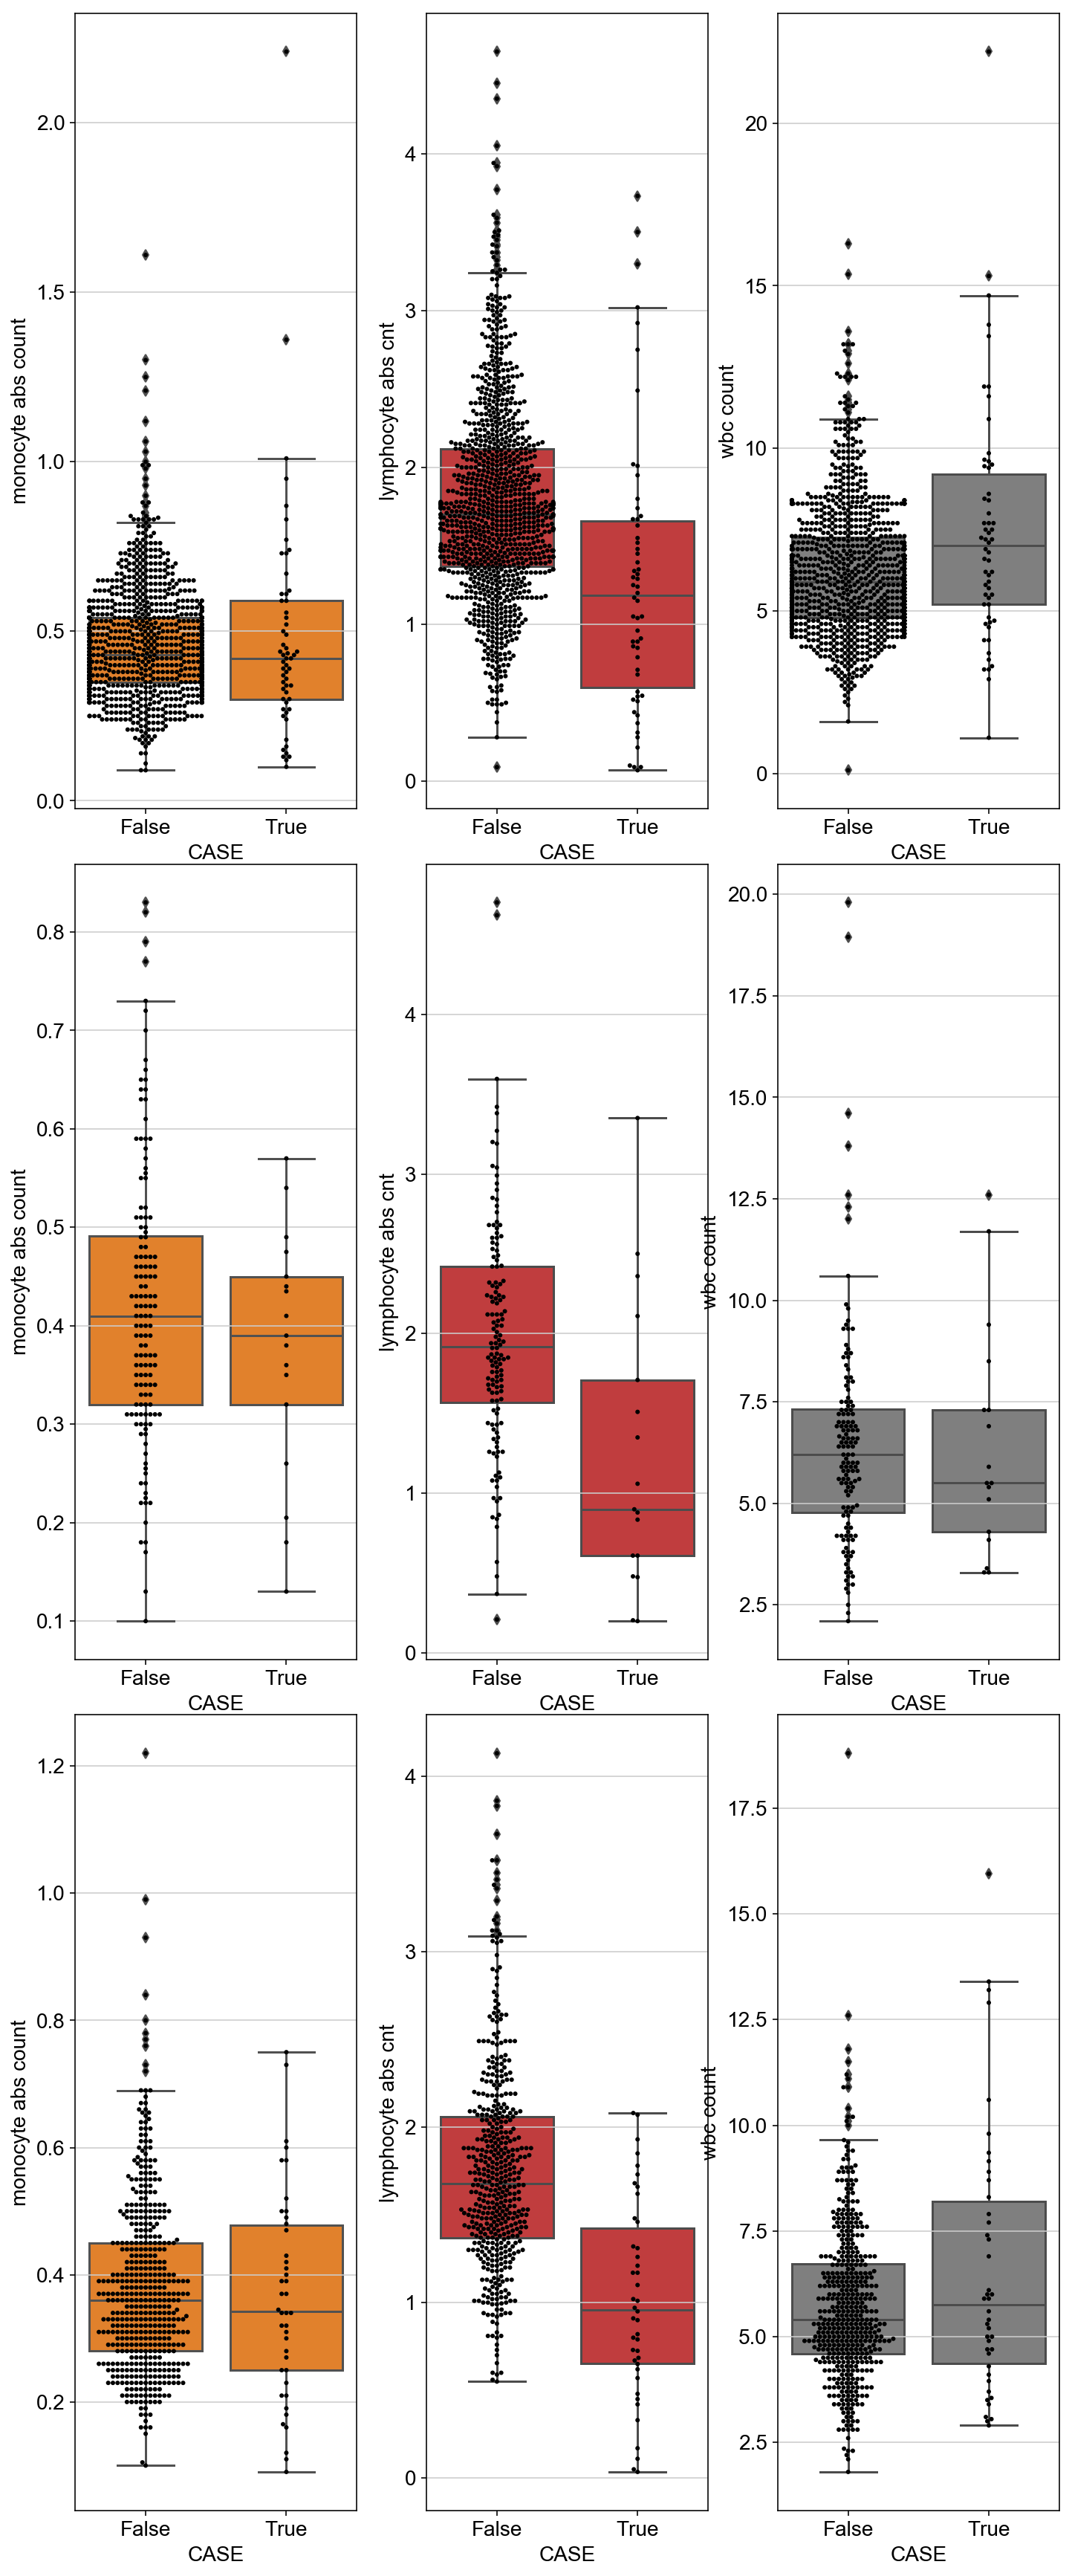

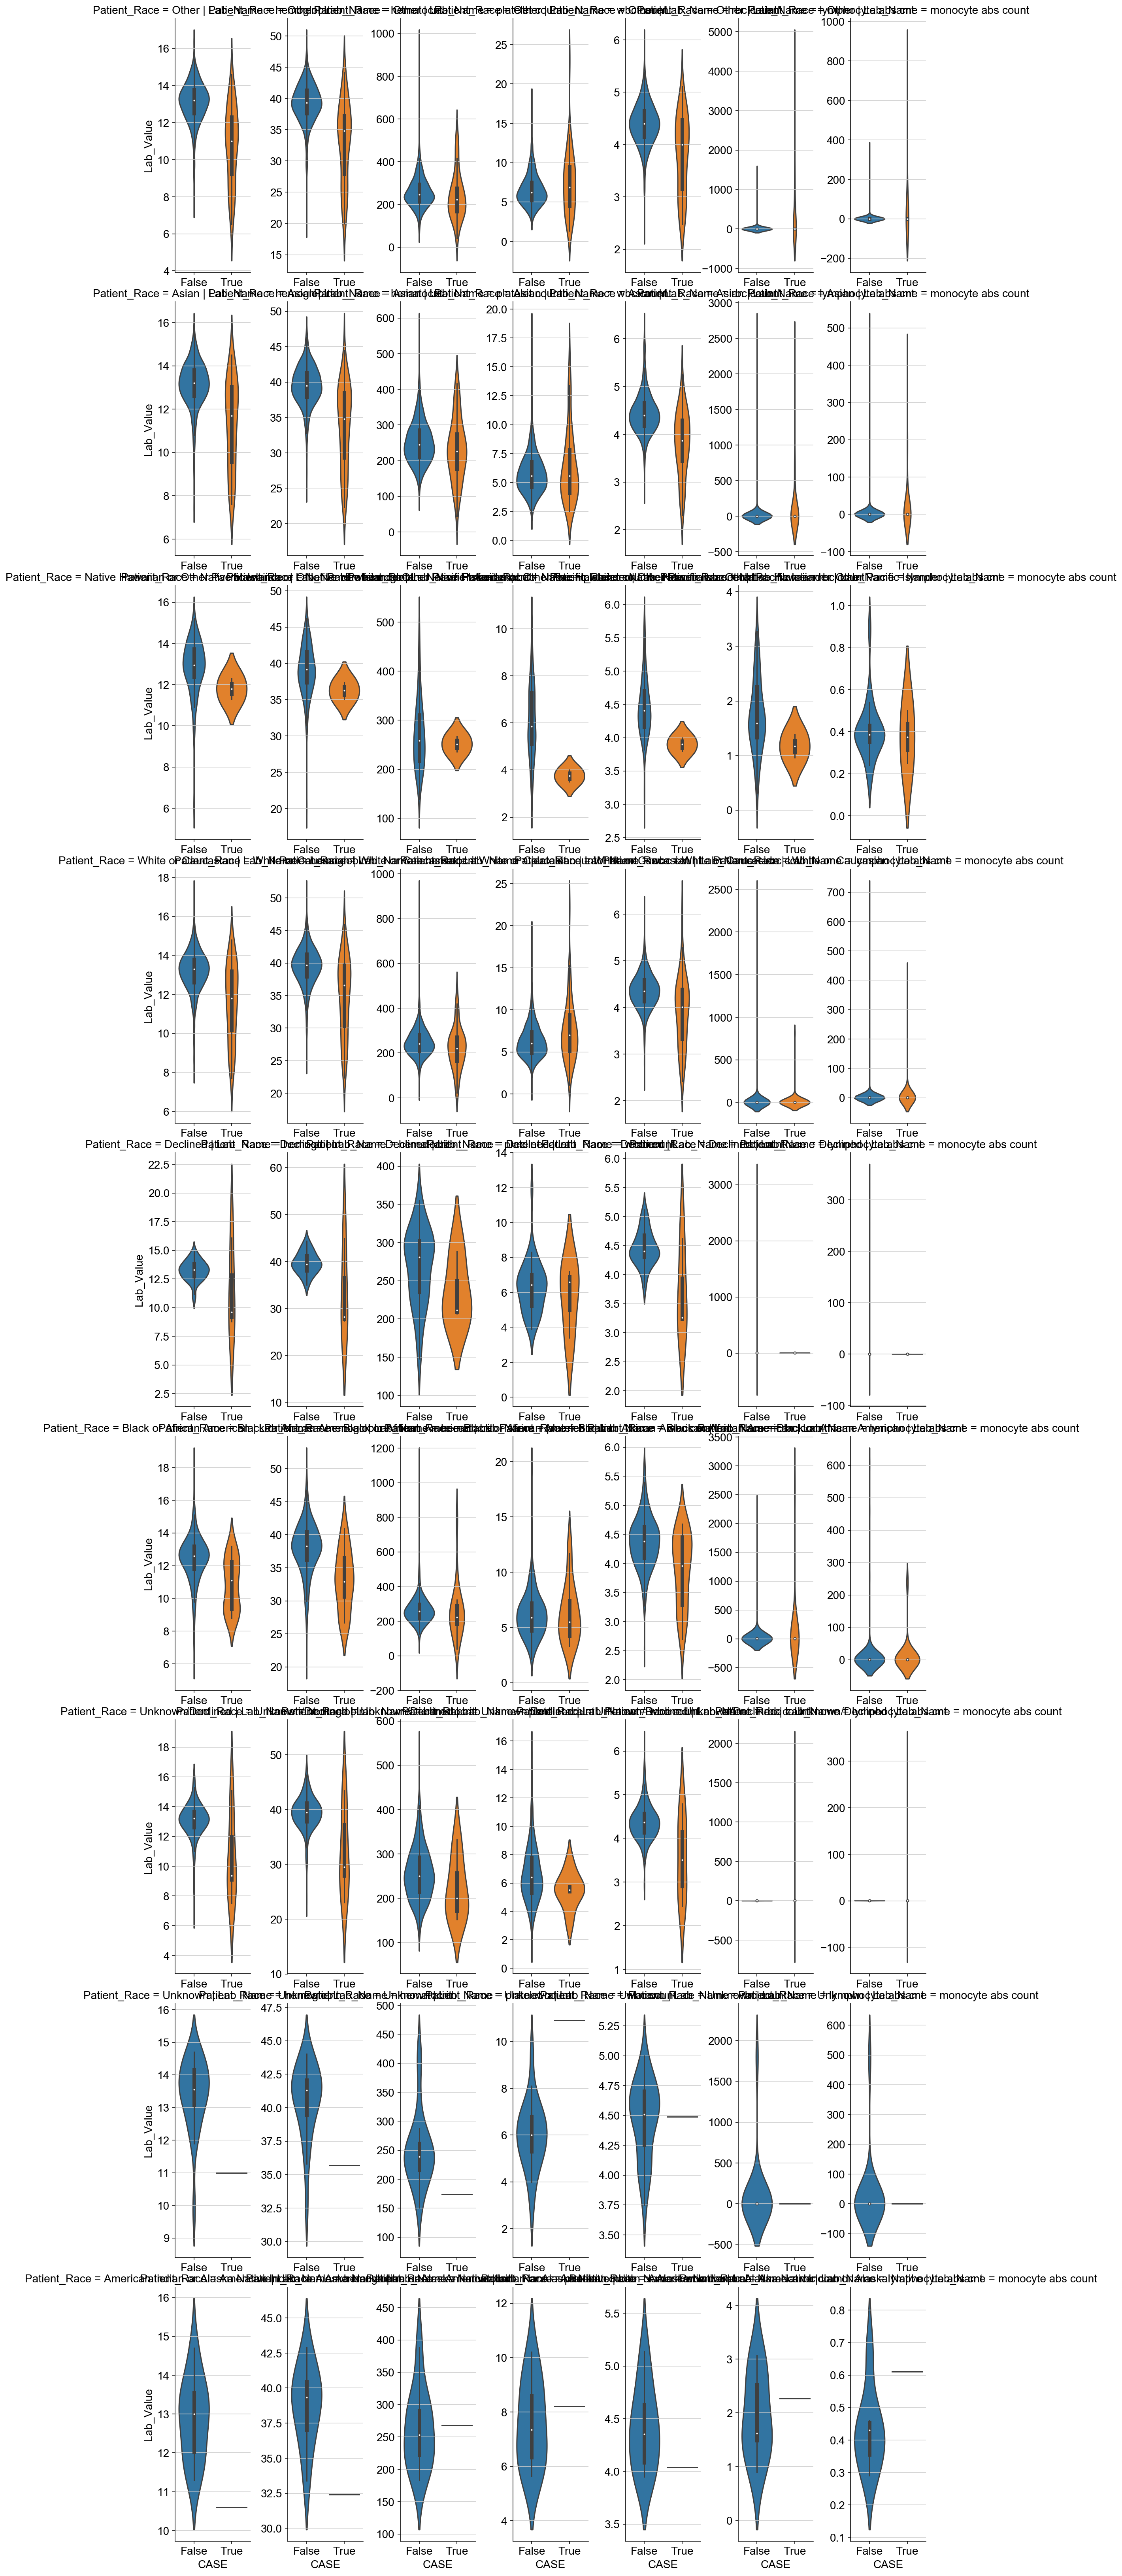

In [57]:
## Now let's analyze the EHR data
ehr = pd.read_table("meena_lupus_2017-11-15.csv", sep=",")
ehr_pivot = ehr.pivot_table(index=['Patient_ID',"Lab_Age","Patient_Sex","Patient_Race","CASE"],columns="Lab_Name",values="Lab_Value")
ehr_pivot.reset_index(inplace=True)
ehr_pivot = ehr_pivot[ehr_pivot['monocyte abs count'] < 5]
ehr_pivot = ehr_pivot[ehr_pivot['lymphocyte abs cnt'] < 6]

fig,ax = plt.subplots(nrows=3,ncols=3, figsize=(10,24))
fig.tight_layout()

## find samples with both monocyte and lymphocyte count
for cg_i in [0, 1, 2] :
    cg = ['monocyte abs count', 'lymphocyte abs cnt', 'wbc count'][cg_i]
    for r_i in [0,1,2] :
        race = ['White or Caucasian', 'Black or African American', 'Asian'][r_i]
        sns.boxplot(x="CASE", y=cg, data=ehr_pivot[ehr_pivot.Patient_Race==race], color=['#ff7f0e','#d62728','#7f7f7f'][cg_i], ax=ax[r_i,cg_i])
        sns.swarmplot(x="CASE", y=cg, data=ehr_pivot[ehr_pivot.Patient_Race==race], color="0", size=3, ax=ax[r_i,cg_i])
           
perc_plot = sns.catplot(x='CASE', y='Lab_Value', col='Lab_Name', data=ehr, kind='violin', row='Patient_Race', dodge=False, aspect=0.4, sharex=False, sharey=False)

## test for differences in abundance
for cg_i in [0, 1] :
    cg = ['monocyte abs count', 'lymphocyte abs cnt'][cg_i]
    for race in ['White or Caucasian', 'Black or African American', 'Asian'] :
        abundance = ehr_pivot[ehr_pivot.Patient_Race==race][cg].values
        disease = ehr_pivot.CASE[ehr_pivot.Patient_Race==race]
        disease = sm.add_constant(disease)
        print('Cell type:'+ ct +",Race:"+race)
        est=sm.OLS(abundance.astype(float), disease.astype(float))
        est=est.fit()
        effect=est.params[1]
        pval=est.pvalues[1]
        print('Beta='+str(effect)+', pvalue='+str(pval))

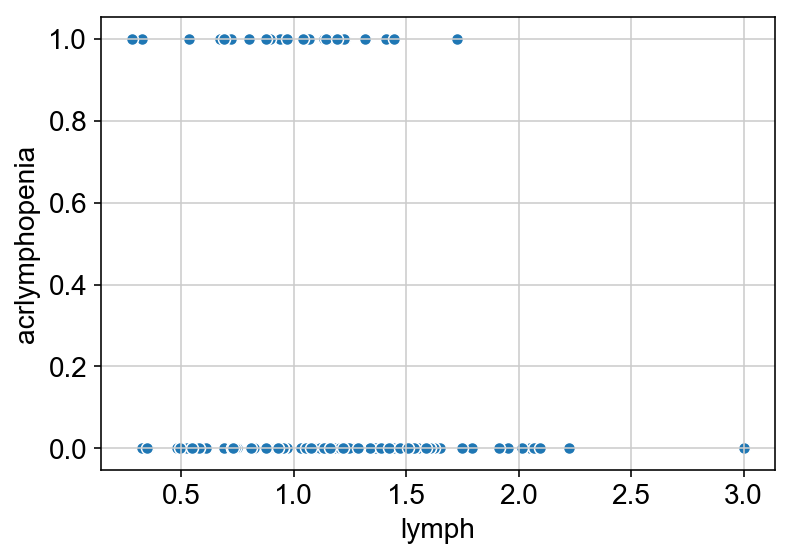

In [58]:
sns.scatterplot(joined_agg_pivot_clues.lymph, joined_agg_pivot_clues.acrlymphopenia)